<a href="https://colab.research.google.com/github/charleswei2003/demo1/blob/main/Reinforcement_Q_learning_for_3D_2048_game.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Before Midpoint Report Version

keeping this part just for reference

## Package Importation

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional
import torch.optim as optim
import warnings
import random

## 3D 2048 Game Implementation

In [ ]:
import numpy as np

class Board_3D():
    def __init__(self, rows=3, cols=3, pipes=3, prob_2=0.9, finish_value=2048):
        self.rows = rows
        self.cols = cols
        self.pipes = pipes
        self.prob_2 = prob_2
        self.finish_value = finish_value
        self.directions = ['Q', 'W', 'E', 'A', 'S', 'D']  # Action mapping
        self.reset()
        # separate reset and _init_ so that custom game setting will be preserved after game is reset

    def reset(self):
        self.board = np.zeros((self.rows, self.cols, self.pipes), dtype=int)
        self.add_2_4()
        self.game_over = False
        self.score = 0
        return self.board.copy()

    def add_2_4(self):
        open_pos = np.argwhere(self.board == 0)
        if open_pos.size > 0:
            new_pos = open_pos[np.random.choice(len(open_pos))]
            self.board[tuple(new_pos)] = 2 if np.random.random() < self.prob_2 else 4

    def tiles_left(self, column):
        non_zero = column[column != 0]
        padded = np.concatenate([[0], non_zero])
        score = 0

        for i in range(1, len(padded)):
            if padded[i] == padded[i-1]:
                padded[i-1] *= 2
                score += padded[i-1]
                padded[i] = 0

        non_zero = padded[padded != 0]
        new_col = np.concatenate([non_zero, np.zeros(len(column) - len(non_zero))])
        return new_col, score

    def action(self, direction):
        d1, ax1, d2, ax2 = 0, (0, 1), 0, (0, 1)  # Default values
        dir_upper = direction.upper()

        if 'A' in dir_upper: d1, ax1, d2, ax2 = 0, (1, 2), 0, (2, 1)
        if 'S' in dir_upper: d1, ax1, d2, ax2 = 1, (2, 1), 0, (2, 1)
        if 'D' in dir_upper: d1, ax1, d2, ax2 = 2, (1, 2), 0, (2, 1)
        if 'W' in dir_upper: d1, ax1, d2, ax2 = 1, (1, 2), 0, (2, 1)
        if 'Q' in dir_upper: d1, ax1, d2, ax2 = 1, (1, 0), 1, (1, 2)
        if 'E' in dir_upper: d1, ax1, d2, ax2 = 1, (0, 1), 1, (1, 2)

        rotated_board = np.rot90(np.rot90(self.board, d1, axes=ax1), d2, axes=ax2)
        rotated_reshaped = rotated_board.reshape(-1, rotated_board.shape[2])

        total_score = 0
        new_columns = []

        for col in rotated_reshaped:
            processed_col, score = self.tiles_left(col)
            new_columns.append(processed_col)
            total_score += score

        new_board = np.array(new_columns).reshape(rotated_board.shape)
        restored = np.rot90(np.rot90(new_board, -d2, axes=ax2), -d1, axes=ax1)

        return restored, total_score

    def check_game_over(self):
      # check three dimension (original just checked two i j)
        if np.any(self.board >= self.finish_value):
            return True
        if (self.board == 0).any():
            return False
        for i in range(self.rows):
            for j in range(self.cols):
                for k in range(self.pipes):
                    current = self.board[i,j,k]
                    if (i < self.rows-1 and current == self.board[i+1,j,k]) or \
                       (j < self.cols-1 and current == self.board[i,j+1,k]) or \
                       (k < self.pipes-1 and current == self.board[i,j,k+1]):
                        return False

        return True

    def step(self, action):
      #add reward/state/done feedback for better RL training
        direction = self.directions[action]
        old_board = self.board.copy()
        new_board, delta_score = self.action(direction)
        moved = not np.array_equal(old_board, new_board)

        if moved:
            self.board = new_board
            self.score += delta_score
            self.add_2_4()

        done = self.check_game_over()
        reward = delta_score if moved else 0
        return self.board.copy(), reward, done, {"valid_move": moved}

## Game Execution (for verification)

In [ ]:
game2 = Board_3D(rows=3, cols=3, pipes=3, prob_2=0.9, finish_value=2048)
print("Initial board:")
print(game2.board, '\n---------------\n')

direction_map = {'Q':0, 'W':1, 'E':2, 'A':3, 'S':4, 'D':5}

while True:
    # Get input
    direction = input('(Q)away | (W)up | (E)toward | (A)left | (S)down | (D)right | (X)exit: ').upper()

    if direction == 'X':
        print("Game exited by user")
        break

    if direction not in direction_map:
        print("Invalid direction! Use Q/W/E/A/S/D/X")
        continue

    # Process move
    action = direction_map[direction]
    new_state, reward, done, info = game2.step(action)

    # Update display
    print(f"Move result ({direction}):")
    print(game2.board, '\n---------------\n')
    print(f"Score: {game2.score}\n")

    # Check termination
    if done:
        print('Game Over! Final score:', game2.score)
        break

Initial board:
[[[0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 2]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]]] 
---------------

(Q)away | (W)up | (E)toward | (A)left | (S)down | (D)right | (X)exit: x
Game exited by user


## Model Construction

In [ ]:
# Suppress numpy log2 warnings
# warnings.filterwarnings("ignore", category=RuntimeWarning)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
BATCH_SIZE = 128 # default: 128
BUFFER_SIZE = 10000  # default: 10000
GAMMA = 0.99
LR = 0.003
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 0.995   ##
TARGET_UPDATE = 10

# Neural Network Architecture
class DQN(nn.Module):
    def __init__(self, input_shape, action_size):
        super(DQN, self).__init__()
        self.input_shape = input_shape
        self.action_size = action_size

        # 3D Convolutional layers
        self.conv1 = nn.Conv3d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(32, 64, kernel_size=3, padding=1)

        # Calculate linear layer input size
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, *input_shape)
            dummy_output = self.conv2(self.conv1(dummy_input))
            linear_input_size = dummy_output.view(1, -1).size(1)

        self.fc1 = nn.Linear(linear_input_size, 512)
        self.fc2 = nn.Linear(512, action_size)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# Experience Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

# DQN Agent
class DQNAgent:
    def __init__(self, input_shape, action_size):
        self.input_shape = input_shape
        self.action_size = action_size
        self.epsilon = EPS_START

        # Initialize networks
        self.policy_net = DQN(input_shape, action_size).to(device)
        self.target_net = DQN(input_shape, action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=LR)
        self.memory = ReplayBuffer(BUFFER_SIZE)

    def preprocess_state(self, state):
        # Convert to log scale and normalize
        with np.errstate(divide='ignore', invalid='ignore'):
            processed = np.where(state > 0, np.log2(state), 0.0)
        processed = processed.astype(np.float32) / 11.0  # log_{2}(2048) = 11
        return torch.tensor(processed, dtype=torch.float32).unsqueeze(0).to(device)

    def select_action(self, state):
        if random.random() > self.epsilon:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.action_size)]],
                               device=device, dtype=torch.long)

    def update_epsilon(self):
        self.epsilon = max(EPS_END, self.epsilon * EPS_DECAY)

    def optimize_model(self):
        if len(self.memory) < BATCH_SIZE:
            return

        transitions = self.memory.sample(BATCH_SIZE)
        batch = list(zip(*transitions))

        # Process state batch
        state_batch = torch.cat([self.preprocess_state(s) for s in batch[0]])

        # Process action batch
        action_batch = torch.cat([a.to(device) for a in batch[1]])

        # Process reward batch
        reward_batch = torch.tensor(batch[2], dtype=torch.float32, device=device)

        # Process next state batch
        next_state_batch = []
        for s in batch[3]:
            if s is not None:
                next_state_batch.append(self.preprocess_state(s))
            else:
                next_state_batch.append(
                    torch.zeros((1, *self.input_shape),
                               dtype=torch.float32,
                               device=device)
                )
        next_state_batch = torch.cat(next_state_batch)

        # Process done batch
        done_batch = torch.tensor(batch[4], dtype=torch.bool, device=device)

        # Compute Q values
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        # Compute target Q values
        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            valid_mask = ~done_batch
            if valid_mask.any():
                next_state_values[valid_mask] = self.target_net(next_state_batch[valid_mask]).max(1)[0]

        expected_state_action_values = (next_state_values * GAMMA) + reward_batch

        # Compute loss
        loss = nn.MSELoss()(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize model
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
        self.optimizer.step()

    def update_target_net(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

# Training Function
def train_agent(env, episodes=1000):
    input_shape = (env.rows, env.cols, env.pipes)
    action_size = 6  # Q, W, E, A, S, D
    agent = DQNAgent(input_shape, action_size)

    scores = []
    max_score = 0

    for episode in range(episodes):
        env.reset()
        state = env.board.copy()
        score = 0
        done = False

        while not done:
            # Preprocess and select action
            processed_state = agent.preprocess_state(state)
            action = agent.select_action(processed_state)

            # Execute action
            _, reward, done, _ = env.step(action.item())
            next_state = env.board.copy()
            score += reward

            # Store transition
            agent.memory.push(
                state,
                action.cpu(),
                float(reward),
                next_state if not done else None,
                done
            )

            # Move to next state
            state = next_state

            # Optimize model
            agent.optimize_model()

        # Update exploration rate
        agent.update_epsilon()

        # Update target network
        if episode % TARGET_UPDATE == 0:
            agent.update_target_net()

        # Track progress
        scores.append(score)
        max_score = max(max_score, score)

        # Progress reporting
        if episode % 10 == 0:
            avg_score = np.mean(scores[-50:]) if episode >= 50 else np.mean(scores)
            print(f"Episode {episode:4d} | Score: {score:6.1f} | "
                  f"Avg: {avg_score:6.1f} | Max: {max_score:6.1f} | "
                  f"ε: {agent.epsilon:.3f}")

    return agent, scores

## Training

### First training result (just for reference)

| Episode   | Score     | Avg      | Max      | ε      |
|-----------|-----------|----------|----------|--------|
| 0         | 7356.0    | 7356.0   | 7356.0   | 0.995  |
| 10        | 3356.0    | 8684.4   | 23248.0  | 0.946  |
| 20        | 4968.0    | 8991.6   | 23248.0  | 0.900  |
| 30        | 13792.0   | 9669.2   | 23248.0  | 0.856  |
| 40        | 8120.0    | 9773.0   | 23248.0  | 0.814  |
| 50        | 876.0     | 9557.0   | 23248.0  | 0.774  |
| 60        | 10812.0   | 9513.7   | 23248.0  | 0.737  |
| 70        | 7500.0    | 9132.2   | 23248.0  | 0.701  |
| 80        | 8116.0    | 8161.0   | 23248.0  | 0.666  |
| 90        | 8496.0    | 7969.0   | 23248.0  | 0.634  |
| 100       | 6792.0    | 8037.7   | 23248.0  | 0.603  |
| 110       | 7524.0    | 7344.5   | 23248.0  | 0.573  |
| 120       | 2364.0    | 7230.1   | 23248.0  | 0.545  |
| 130       | 7944.0    | 7400.6   | 23248.0  | 0.519  |
| 140       | 5916.0    | 7386.6   | 23248.0  | 0.493  |
| 150       | 4344.0    | 7093.2   | 23248.0  | 0.469  |
| 160       | 2644.0    | 7737.8   | 23248.0  | 0.446  |
| 170       | 6576.0    | 8111.4   | 23248.0  | 0.424  |
| 180       | 6748.0    | 8145.3   | 23248.0  | 0.404  |
| 190       | 3976.0    | 8106.6   | 23248.0  | 0.384  |
| 200       | 8540.0    | 7840.2   | 23248.0  | 0.365  |
| 210       | 2428.0    | 7355.7   | 23248.0  | 0.347  |
| 220       | 3544.0    | 7095.4   | 23248.0  | 0.330  |
| 230       | 7680.0    | 7170.0   | 23248.0  | 0.314  |
| 240       | 7304.0    | 6680.6   | 23248.0  | 0.299  |
| 250       | 12668.0   | 6841.9   | 23248.0  | 0.284  |
| 260       | 7792.0    | 6964.7   | 23248.0  | 0.270  |
| 270       | 4408.0    | 6811.4   | 23248.0  | 0.257  |
| 280       | 7432.0    | 6661.3   | 23248.0  | 0.245  |
| 290       | 5548.0    | 6490.1   | 23248.0  | 0.233  |

In [ ]:
torch.save(trained_agent.policy_net.state_dict(), '3d_2048_dqn.pth')

## Testing

Potential Reason: agent can't correctly interact with board. When agent input "E" action (see testing output below), although there is no valid move of blocks, we still expect to see new blocks spawned in next step. The failure of new block spawning lead to agent constantly inputting same action.

In [ ]:
def ai_play(env, agent, num_episodes=10, render=True):
    results = []

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        max_tile = 0
        move_count = 0

        while not done:
            # Preprocess state
            processed_state = agent.preprocess_state(state)

            # Get AI action
            with torch.no_grad():
                action = agent.policy_net(processed_state).max(1)[1].item()

            # Execute action
            next_state, reward, done, _ = env.step(action)

            # Update metrics
            total_reward += reward
            current_max = np.max(next_state)
            max_tile = max(max_tile, current_max)
            move_count += 1

            if render:
                print(f"Move {move_count}:")
                print(env.board)  # Assuming your board has a readable __str__ method
                print(f"Action: {env.directions[action]} | Reward: {reward}")
                print("-" * 30)

            state = next_state

        results.append({
            'episode': episode + 1,
            'score': total_reward,
            'max_tile': max_tile,
            'moves': move_count
        })

        print(f"Episode {episode+1} completed!")
        print(f"Final Score: {total_reward}")
        print(f"Max Tile: {max_tile}")
        print(f"Total Moves: {move_count}")
        print("=" * 50)

    # Print summary
    print("\n=== AI Performance Summary ===")
    print(f"Total Episodes: {num_episodes}")
    print(f"Average Score: {np.mean([r['score'] for r in results]):.1f}")
    print(f"Best Score: {max([r['score'] for r in results])}")
    print(f"Highest Tile Achieved: {2**max([r['max_tile'] for r in results])}")

    return results

# Usage example:
if __name__ == "__main__":
    # Load trained agent
    trained_agent = DQNAgent(input_shape=(3, 3, 3), action_size=6)
    trained_agent.policy_net.load_state_dict(torch.load('3d_2048_dqn.pth'))
    trained_agent.policy_net.eval()  # Set to evaluation mode

    # Create environment
    env = Board_3D(rows=3, cols=3, pipes=3)

    # Watch the AI play 3 games with visualization
    ai_results = ai_play(env, trained_agent, num_episodes=3, render=True)

    # For batch testing without visualization
    # ai_results = ai_play(env, trained_agent, num_episodes=100, render=False)

<ipython-input-31-5663c8d32490>:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_agent.policy_net.load_state_dict(torch.load('3d_2048_dqn.pth'))


流式输出内容被截断，只能显示最后 5000 行内容。
Action: E | Reward: 0
------------------------------
Move 297:
[[[0. 0. 4.]
  [0. 0. 0.]
  [0. 4. 2.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
Action: E | Reward: 0
------------------------------
Move 298:
[[[0. 0. 4.]
  [0. 0. 0.]
  [0. 4. 2.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
Action: E | Reward: 0
------------------------------
Move 299:
[[[0. 0. 4.]
  [0. 0. 0.]
  [0. 4. 2.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
Action: E | Reward: 0
------------------------------
Move 300:
[[[0. 0. 4.]
  [0. 0. 0.]
  [0. 4. 2.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
Action: E | Reward: 0
------------------------------
Move 301:
[[[0. 0. 4.]
  [0. 0. 0.]
  [0. 4. 2.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
Action: E | Reward: 0
---------------------

KeyboardInterrupt: 

# After Midpoint Report Version

## Package Importation

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import warnings
import random
import time
import matplotlib.pyplot as plt

## Game Implementation

In [ ]:
class Board_3D:
    def __init__(self, rows=3, cols=3, pipes=3, prob_2=0.9, finish_value=2048):
        self.rows = rows
        self.cols = cols
        self.pipes = pipes
        self.prob_2 = prob_2
        self.finish_value = finish_value
        self.directions = ['Q', 'W', 'E', 'A', 'S', 'D']  # Action mapping
        self.reset()

    def reset(self):
        self.board = np.zeros((self.rows, self.cols, self.pipes), dtype=np.int64)
        self.add_2_4()
        self.game_over = False
        self.score = 0
        return self.board.copy()

    def add_2_4(self):
        open_pos = np.argwhere(self.board == 0)
        if open_pos.size > 0:
            new_pos = open_pos[np.random.choice(len(open_pos))]
            self.board[tuple(new_pos)] = 2 if np.random.random() < self.prob_2 else 4

    def tiles_left(self, column):
        non_zero = column[column != 0]
        padded = np.concatenate([[0], non_zero])
        score = 0

        for i in range(1, len(padded)):
            if padded[i] == padded[i-1]:
                padded[i-1] *= 2
                score += padded[i-1]
                padded[i] = 0

        non_zero = padded[padded != 0]
        new_col = np.concatenate([non_zero, np.zeros(len(column) - len(non_zero))])
        return new_col, score

    def action(self, direction):
        d1, ax1, d2, ax2 = 0, (0, 1), 0, (0, 1)  # Default values
        dir_upper = direction.upper()

        if 'A' in dir_upper: d1, ax1, d2, ax2 = 0, (1, 2), 0, (2, 1)
        if 'S' in dir_upper: d1, ax1, d2, ax2 = 1, (2, 1), 0, (2, 1)
        if 'D' in dir_upper: d1, ax1, d2, ax2 = 2, (1, 2), 0, (2, 1)
        if 'W' in dir_upper: d1, ax1, d2, ax2 = 1, (1, 2), 0, (2, 1)
        if 'Q' in dir_upper: d1, ax1, d2, ax2 = 1, (1, 0), 1, (1, 2)
        if 'E' in dir_upper: d1, ax1, d2, ax2 = 1, (0, 1), 1, (1, 2)

        rotated_board = np.rot90(np.rot90(self.board, d1, axes=ax1), d2, axes=ax2)
        rotated_reshaped = rotated_board.reshape(-1, rotated_board.shape[2])

        total_score = 0
        new_columns = []

        for col in rotated_reshaped:
            processed_col, score = self.tiles_left(col)
            new_columns.append(processed_col)
            total_score += score

        new_board = np.array(new_columns).reshape(rotated_board.shape)
        restored = np.rot90(np.rot90(new_board, -d2, axes=ax2), -d1, axes=ax1)

        return restored, total_score

    def check_game_over(self):
        if np.any(self.board >= self.finish_value):
            return True
        if (self.board == 0).any():
            return False
        for i in range(self.rows):
            for j in range(self.cols):
                for k in range(self.pipes):
                    current = self.board[i,j,k]
                    if (i < self.rows-1 and current == self.board[i+1,j,k]) or \
                       (j < self.cols-1 and current == self.board[i,j+1,k]) or \
                       (k < self.pipes-1 and current == self.board[i,j,k+1]):
                        return False
        return True

    def step(self, action):
        direction = self.directions[action]
        old_board = self.board.view()  # use view instead of copy to improve performence
        new_board, delta_score = self.action(direction)
        moved = not np.array_equal(old_board, new_board)

        reward = 0
        if moved:
            self.board = new_board
            self.score += delta_score
            reward += delta_score

            max_tile = np.max(new_board)
            if max_tile > np.max(old_board):
                reward += np.log2(max_tile) * 10

            self.add_2_4()
        else:
            reward -= 1

        done = self.check_game_over()
        return self.board.copy(), reward, done, {"valid_move": moved}

    def get_valid_actions(self):
      valid_actions = []
      current_board = self.board.copy()
      for action in range(6):  # 6 actions: Q, W, E, A, S, D
        direction = self.directions[action]
        new_board, _ = self.action(direction)
        if not np.array_equal(current_board, new_board):
            valid_actions.append(action)
      return valid_actions

## Model Construction

In [ ]:
# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameter
BATCH_SIZE = 8192
BUFFER_SIZE = 100000
GAMMA = 0.99
LR = 0.0001
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 0.995
TARGET_UPDATE = 10


class OptimizedReplayBuffer:
    def __init__(self, capacity, state_shape):
        self.capacity = capacity
        self.index = 0
        self.size = 0

        # pre-allocation of memory
        self.states = np.zeros((capacity, *state_shape), dtype=np.int64)
        self.actions = np.zeros(capacity, dtype=np.int64)
        self.rewards = np.zeros(capacity, dtype=np.float32)
        self.next_states = np.zeros((capacity, *state_shape), dtype=np.int64)
        self.dones = np.zeros(capacity, dtype=np.bool_)

    def push(self, state, action, reward, next_state, done):
        idx = self.index % self.capacity
        self.states[idx] = state
        self.actions[idx] = action
        self.rewards[idx] = reward
        self.next_states[idx] = next_state if next_state is not None else -1
        self.dones[idx] = done
        self.index = (self.index + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample(self, batch_size):
        indices = np.random.choice(self.size, batch_size, replace=False)
        return (
            self.states[indices],
            self.actions[indices],
            self.rewards[indices],
            self.next_states[indices],
            self.dones[indices]
        )

    def __len__(self):
        return self.size


class ResidualBlock3D(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock3D, self).__init__()
        self.conv1 = nn.Conv3d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(channels)
        self.conv2 = nn.Conv3d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(channels)

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        return F.relu(out)


class DuelingDQN(nn.Module):
    def __init__(self, input_shape, action_size):
        super(DuelingDQN, self).__init__()
        self.input_shape = input_shape
        self.action_size = action_size

        # Feature extraction layers
        self.conv1 = nn.Conv3d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(32)
        self.res1 = ResidualBlock3D(32)

        self.conv2 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(64)
        self.res2 = ResidualBlock3D(64)

        # Calculate linear layer input size with corrected dimension ordering (pipes, rows, cols)
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, input_shape[2], input_shape[0], input_shape[1])
            dummy_output = self.feature_extraction(dummy_input)
            linear_input_size = dummy_output.view(1, -1).size(1)

        # Value stream (dropout removed for RL stability)
        self.value_stream = nn.Sequential(
            nn.Linear(linear_input_size, 512),
            nn.ReLU(),
            # nn.Dropout(0.2),  # Dropout removed for more stable Q-value estimates
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

        # Advantage stream (dropout removed for RL stability)
        self.advantage_stream = nn.Sequential(
            nn.Linear(linear_input_size, 512),
            nn.ReLU(),
            # nn.Dropout(0.2),  # Dropout removed for more stable Q-value estimates
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, action_size)
        )

    def feature_extraction(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.res1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.res2(x)
        return x

    def forward(self, x):
        features = self.feature_extraction(x)
        features = features.view(features.size(0), -1)
        values = self.value_stream(features)
        advantages = self.advantage_stream(features)
        qvals = values + (advantages - advantages.mean(dim=1, keepdim=True))
        return qvals


class DQNAgent:
    def __init__(self, input_shape, action_size):
        self.input_shape = input_shape
        self.action_size = action_size
        self.epsilon = EPS_START

        # Initialize networks
        self.policy_net = DuelingDQN(input_shape, action_size).to(device)
        self.target_net = DuelingDQN(input_shape, action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=LR, weight_decay=1e-5)

        # Initialize optimized replay buffer in memory
        self.memory = OptimizedReplayBuffer(BUFFER_SIZE, input_shape)

        # Pre-allocation of preprocess buffer: shape (batch, channel, pipes, rows, cols)
        self.preprocess_buffer = torch.empty(
            (BATCH_SIZE, 1, input_shape[2], input_shape[0], input_shape[1]),
            device=device,
            dtype=torch.float32
        )

    def preprocess_batch(self, states):
        with np.errstate(divide='ignore', invalid='ignore'):
            log_states = np.log2(np.where(states > 0, states, 1)) / 11.0
        # Convert from (batch, rows, cols, pipes) to (batch, pipes, rows, cols)
        log_states = np.transpose(log_states, (0, 3, 1, 2))
        log_states = np.expand_dims(log_states, 1)  # (batch, channel, pipes, rows, cols)

        # Use the preallocated buffer to avoid repeated memory allocation
        self.preprocess_buffer[:len(states)] = torch.from_numpy(log_states).float()
        return self.preprocess_buffer[:len(states)]

    def preprocess_single_state(self, state):
        with np.errstate(divide='ignore', invalid='ignore'):
            processed = np.log2(np.where(state > 0, state, 1)) / 11.0
        processed = np.transpose(processed, (2, 0, 1))  # (pipes, rows, cols)
        processed = np.expand_dims(processed, 0)         # (1, rows, cols, pipes)
        processed = np.expand_dims(processed, 1)         # (1, channel, rows, cols, pipes)
        return torch.from_numpy(processed).float().to(device)

    def select_action(self, state):
        if random.random() > self.epsilon:
            with torch.no_grad():
                q_values = self.policy_net(state)
                return q_values.max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.action_size)]],
                                device=device, dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < BATCH_SIZE:
            return

        # Sample batches
        states, actions, rewards, next_states, dones = self.memory.sample(BATCH_SIZE)
        state_batch = self.preprocess_batch(states)
        next_state_batch = self.preprocess_batch(next_states)

        action_batch = torch.tensor(actions, device=device).unsqueeze(1)
        reward_batch = torch.tensor(rewards, device=device)
        done_batch = torch.tensor(dones, device=device)

        # Q-value calculation
        current_q_values = self.policy_net(state_batch).gather(1, action_batch)

        next_q_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            next_q_values[~done_batch] = self.target_net(next_state_batch[~done_batch]).max(1)[0]

        target_q_values = (next_q_values * GAMMA) + reward_batch

        # Loss Computation and Parameter Optimization
        loss = F.smooth_l1_loss(current_q_values, target_q_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
        self.optimizer.step()
        # Removed torch.cuda.empty_cache() for improved training speed

    def update_epsilon(self):
        self.epsilon = max(EPS_END, self.epsilon * EPS_DECAY)

    def update_target_net(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())


## Training

In [ ]:
def train_agent(env, episodes=100, agent=None, start_episode=0):
    input_shape = (env.rows, env.cols, env.pipes)
    action_size = 6  # Q, W, E, A, S, D

    # Create a new agent only if one is not provided
    if agent is None:
        agent = DQNAgent(input_shape, action_size)

    scores = []
    max_score = 0
    max_tile = 0
    start_time = time.time()

    # Performance Monitoring
    times = {
        'state_processing': 0,
        'action_selection': 0,
        'env_step': 0,
        'memory_push': 0,
        'optimization': 0
    }

    print("Starting training...")

    try:
        for episode in range(start_episode, start_episode + episodes):
            episode_start_time = time.time()
            state = env.reset()
            score = 0
            done = False
            steps = 0
            valid_moves = 0
            invalid_moves = 0

            print(f"\nStarting Episode {episode}")

            while not done:
                steps += 1

                t0 = time.time()
                processed_state = agent.preprocess_single_state(state)
                times['state_processing'] += time.time() - t0

                t0 = time.time()
                action = agent.select_action(processed_state)
                times['action_selection'] += time.time() - t0

                t0 = time.time()
                next_state, reward, done, info = env.step(action.item())
                times['env_step'] += time.time() - t0

                if info['valid_move']:
                    valid_moves += 1
                else:
                    invalid_moves += 1

                t0 = time.time()
                agent.memory.push(
                    state,
                    action.item(),
                    reward,
                    next_state if not done else None,
                    done
                )
                times['memory_push'] += time.time() - t0

                state = next_state
                score += reward

                t0 = time.time()
                agent.optimize_model()
                times['optimization'] += time.time() - t0

                # Print training status every 100 steps
                if steps % 100 == 0:
                    current_max_tile = np.max(state)
                    print(f"  Step {steps}: Score={score:.1f}, MaxTile={current_max_tile}, "
                          f"Valid/Invalid moves={valid_moves}/{invalid_moves}")

                # Safety check: terminate episode if too many steps
                if steps > 5000:
                    print("  Reached step limit - ending episode")
                    done = True

            # Update epsilon and target network after each episode
            agent.update_epsilon()
            if episode % TARGET_UPDATE == 0:
                agent.update_target_net()

            # Record the scores and update statistics
            scores.append(score)
            max_score = max(max_score, score)
            max_tile = max(max_tile, np.max(state))

            episode_time = time.time() - episode_start_time
            avg_score = np.mean(scores[-50:]) if episode >= 50 else np.mean(scores)
            steps_per_second = steps / episode_time

            # Episode summary
            print(f"\nEpisode {episode} Summary:")
            print(f"  Score: {score:.1f} | Avg: {avg_score:.1f} | Max: {max_score:.1f}")
            print(f"  Max Tile: {max_tile} | Steps: {steps} | Time: {episode_time:.1f}s")
            print(f"  Steps/second: {steps_per_second:.1f}")
            print(f"  Valid/Invalid moves: {valid_moves}/{invalid_moves}")
            print(f"  Epsilon: {agent.epsilon:.3f}")

            # Print performance statistics every 10 episodes
            if episode % 10 == 0:
                print("\nPerformance Statistics:")
                total_time = sum(times.values())
                for key, value in times.items():
                    percentage = (value / total_time * 100) if total_time > 0 else 0
                    print(f"  {key}: {value:.2f}s ({percentage:.1f}%)")
                times = {k: 0 for k in times}

            # Checkpoint saving every 10 episodes
            if episode % 10 == 0:
                checkpoint = {
                    'episode': episode,
                    'policy_net_state_dict': agent.policy_net.state_dict(),
                    'target_net_state_dict': agent.target_net.state_dict(),
                    'optimizer_state_dict': agent.optimizer.state_dict(),
                    'epsilon': agent.epsilon,
                    'scores': scores
                }
                torch.save(checkpoint, f'checkpoint_episode_{episode}.pth')
                print(f"  Saved checkpoint to checkpoint_episode_{episode}.pth")

            # GPU memory cleanup
            if episode % 10 == 0 and hasattr(torch.cuda, 'empty_cache'):
                torch.cuda.empty_cache()

    except KeyboardInterrupt:
        print("\nTraining interrupted by user")

    finally:
        total_time = time.time() - start_time
        print(f"\nTraining completed in {total_time:.1f} seconds")
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()

    return agent, scores

def load_checkpoint(agent, path):
    checkpoint = torch.load(path)
    agent.policy_net.load_state_dict(checkpoint['policy_net_state_dict'])
    agent.target_net.load_state_dict(checkpoint['target_net_state_dict'])
    agent.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    agent.epsilon = checkpoint['epsilon']

    return checkpoint['episode'], checkpoint['scores']


In [ ]:
if __name__ == "__main__":
    env = Board_3D(rows=3, cols=3, pipes=3)
    input_shape = (env.rows, env.cols, env.pipes)
    action_size = 6

    # Input the correct name of checkpoint file!!
    checkpoint_path = 'checkpoint_episode_0.pth'
    try:
        # Load parameters into
        agent = DQNAgent(input_shape, action_size)
        start_episode, scores = load_checkpoint(agent, checkpoint_path)
        print(f"Loaded checkpoint from episode {start_episode}")
    except FileNotFoundError:
        print("No checkpoint found; starting fresh.")
        agent = None
        start_episode = 0
        scores = []

    # Continue training (or start fresh if no checkpoint was loaded)
    agent, scores = train_agent(env, episodes=500, agent=agent, start_episode=start_episode)


<ipython-input-4-e921956bd092>:145: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


No checkpoint found; starting fresh.
Starting training...

Starting Episode 0
  Step 100: Score=883.0, MaxTile=64.0, Valid/Invalid moves=91/9
  Step 200: Score=2373.0, MaxTile=256.0, Valid/Invalid moves=175/25
  Step 300: Score=3465.0, MaxTile=256.0, Valid/Invalid moves=263/37
  Step 400: Score=4331.0, MaxTile=256.0, Valid/Invalid moves=349/51
  Step 500: Score=6495.0, MaxTile=512.0, Valid/Invalid moves=439/61
  Step 600: Score=7883.0, MaxTile=512.0, Valid/Invalid moves=531/69
  Step 700: Score=11052.0, MaxTile=1024.0, Valid/Invalid moves=620/80
  Step 800: Score=12089.0, MaxTile=1024.0, Valid/Invalid moves=709/91

Episode 0 Summary:
  Score: 13157.0 | Avg: 13157.0 | Max: 13157.0
  Max Tile: 1024.0 | Steps: 898 | Time: 0.5s
  Steps/second: 1936.2
  Valid/Invalid moves: 787/111
  Epsilon: 0.995

Performance Statistics:
  state_processing: 0.10s (22.2%)
  action_selection: 0.04s (9.2%)
  env_step: 0.28s (60.9%)
  memory_push: 0.03s (7.5%)
  optimization: 0.00s (0.3%)
  Saved checkpoint t

## Trends in scores

Data for all 274 episodes successfully extracted.


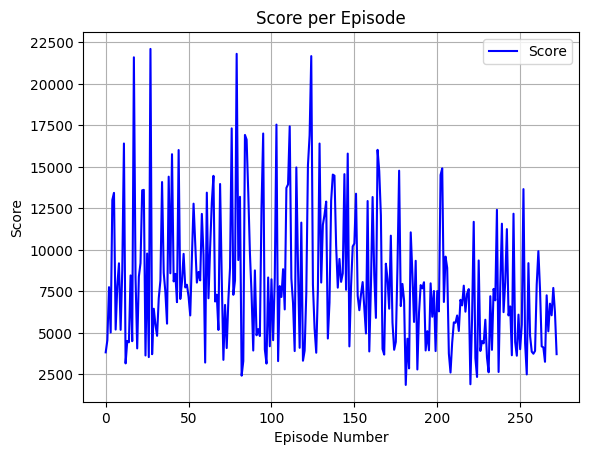

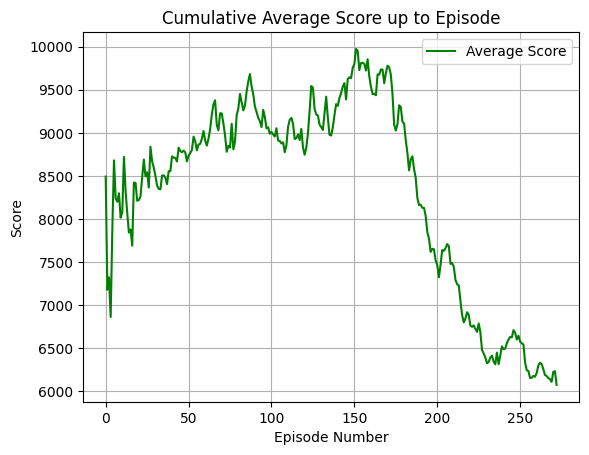

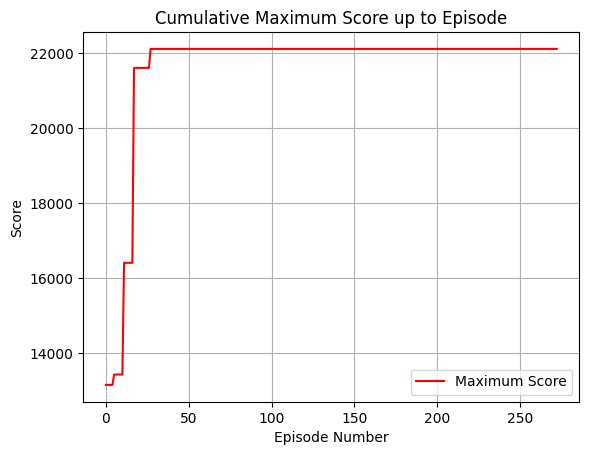

In [ ]:
# Import required libraries
import re
import matplotlib.pyplot as plt

# Read the text file containing episode data
with open('/content/test 1 - 副本.txt', 'r') as file:
    document = file.read()

# Define the regular expression pattern to extract scores
# Matches lines like "Score: X | Avg: Y | Max: Z" where X, Y, Z are numbers with decimals
pattern = re.compile(r"Score: (\d+\.\d+) \| Avg: (\d+\.\d+) \| Max: (\d+\.\d+)")

# Find all matches in the document
matches = pattern.findall(document)

# Extract scores, average scores, and maximum scores into separate lists
scores = [float(match[0]) for match in matches]  # Individual episode scores
avg_scores = [float(match[1]) for match in matches]  # Cumulative average scores
max_scores = [float(match[2]) for match in matches]  # Cumulative maximum scores

# Check if we have data for all 274 episodes
if len(matches) != 273:
    print(f"Warning: Found {len(matches)} episodes instead of the expected 274.")
else:
    print("Data for all 274 episodes successfully extracted.")

# Create a list of episode numbers (0 to 273)
episodes = list(range(273))

# Create the first graph: Score per Episode
fig1, ax1 = plt.subplots()
ax1.plot(episodes, scores, label='Score', color='blue')
ax1.set_xlabel('Episode Number')
ax1.set_ylabel('Score')
ax1.set_title('Score per Episode')
ax1.legend()
ax1.grid(True)  # Add grid lines for better readability

# Create the second graph: Cumulative Average Score up to Episode
fig2, ax2 = plt.subplots()
ax2.plot(episodes, avg_scores, label='Average Score', color='green')
ax2.set_xlabel('Episode Number')
ax2.set_ylabel('Score')
ax2.set_title('Cumulative Average Score up to Episode')
ax2.legend()
ax2.grid(True)

# Create the third graph: Cumulative Maximum Score up to Episode
fig3, ax3 = plt.subplots()
ax3.plot(episodes, max_scores, label='Maximum Score', color='red')
ax3.set_xlabel('Episode Number')
ax3.set_ylabel('Score')
ax3.set_title('Cumulative Maximum Score up to Episode')
ax3.legend()
ax3.grid(True)

# Display all three graphs
plt.show()

## Testing

Streaming output truncated to the last 5000 lines.
  [  4.   8.  16.]
  [  8.   4.   8.]]

 [[  2.   8.  16.]
  [  0.   2.   4.]
  [  0.   0.   2.]]]
Action: W | Reward: 24.0
Valid Move: True
------------------------------
Move 185:
[[[ 16.  32. 128.]
  [  8.  16.   2.]
  [  2.   8.  16.]]

 [[  8.  16.  64.]
  [  4.   8.  16.]
  [  8.   4.   8.]]

 [[  2.   8.  16.]
  [  2.   4.   0.]
  [  2.   0.   4.]]]
Action: A | Reward: 0
Valid Move: True
------------------------------
Move 186:
[[[ 16.  32. 128.]
  [  8.  16.   2.]
  [  2.   8.  16.]]

 [[  8.  16.  64.]
  [  4.   8.  16.]
  [  8.   4.   8.]]

 [[  2.   8.  16.]
  [  0.   2.   4.]
  [  2.   2.   4.]]]
Action: D | Reward: 0
Valid Move: True
------------------------------
Move 187:
[[[ 16.  32. 128.]
  [  8.  16.   2.]
  [  2.   8.  16.]]

 [[  8.  16.  64.]
  [  4.   8.  16.]
  [  8.   4.   8.]]

 [[  2.   8.  16.]
  [  2.   2.   4.]
  [  0.   4.   4.]]]
Action: D | Reward: 4.0
Valid Move: True
------------------------------
Move

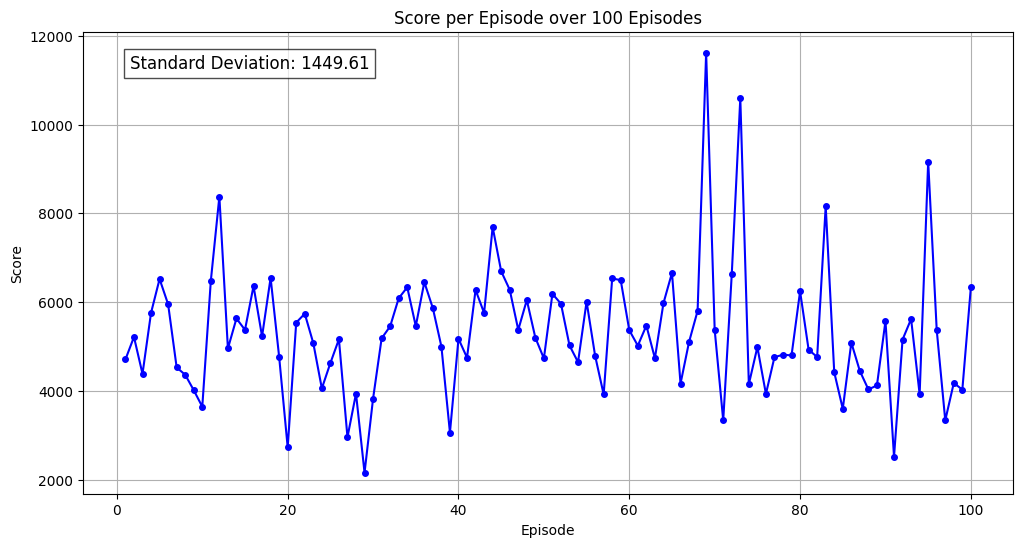

In [ ]:
def ai_play(env, agent, num_episodes=3, render=True):
    """
    Function to test the trained agent by playing the game.

    Args:
        env: The 3D 2048 game environment (Board_3D instance).
        agent: The trained DQNAgent instance.
        num_episodes: Number of episodes to play (default: 3).
        render: Whether to print the board and move details (default: True).

    Returns:
        List of dictionaries with results for each episode.
    """
    results = []

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        max_tile = 0
        move_count = 0

        while not done:
            # Preprocess the current state
            processed_state = agent.preprocess_single_state(state)

            # Get valid actions from the environment
            valid_actions = env.get_valid_actions()

            # Select the best action based on the policy network
            if valid_actions:
                with torch.no_grad():
                    q_values = agent.policy_net(processed_state).squeeze(0)  # Shape: [6]
                    valid_q_values = q_values[valid_actions]  # Q-values for valid actions
                    action = valid_actions[torch.argmax(valid_q_values).item()]
            else:
                # No valid actions indicate the game is over
                done = True
                break

            # Take a step in the environment
            next_state, reward, done, info = env.step(action)

            # Update metrics
            total_reward += reward
            current_max = np.max(next_state)
            max_tile = max(max_tile, current_max)
            move_count += 1

            # Render the game state if enabled
            if render:
                print(f"Move {move_count}:")
                print(env.board)
                print(f"Action: {env.directions[action]} | Reward: {reward}")
                print(f"Valid Move: {info['valid_move']}")
                print("-" * 30)

            state = next_state

        # Store episode results
        results.append({
            'episode': episode + 1,
            'score': total_reward,
            'max_tile': max_tile,
            'moves': move_count
        })

        # Print episode summary
        print(f"Episode {episode + 1} completed!")
        print(f"Final Score: {total_reward}")
        print(f"Max Tile: {max_tile}")
        print(f"Total Moves: {move_count}")
        print("=" * 50)

    # Print overall summary
    print("\n=== AI Performance Summary ===")
    print(f"Total Episodes: {num_episodes}")
    print(f"Average Score: {np.mean([r['score'] for r in results]):.1f}")
    print(f"Best Score: {max([r['score'] for r in results])}")
    print(f"Highest Tile Achieved: {max([r['max_tile'] for r in results])}")

    return results

if __name__ == "__main__":
    # Import Matplotlib for plotting
    import matplotlib.pyplot as plt

    # Define parameters
    input_shape = (3, 3, 3)  # rows, cols, pipes
    action_size = 6  # Number of possible actions (Q, W, E, A, S, D)
    checkpoint_path = 'checkpoint_episode_190.pth'  # Adjust this to your last checkpoint

    # Initialize the agent
    trained_agent = DQNAgent(input_shape, action_size)

    # Load the trained model from the checkpoint
    try:
        checkpoint = torch.load(checkpoint_path, weights_only=False)  # weights_only=False for compatibility
        trained_agent.policy_net.load_state_dict(checkpoint['policy_net_state_dict'])
        trained_agent.policy_net.eval()  # Set to evaluation mode
        print(f"Successfully loaded model from {checkpoint_path}")
    except FileNotFoundError:
        print(f"Error: Checkpoint file '{checkpoint_path}' not found. Please ensure training has completed and the file exists.")
        exit(1)

    # Create the environment
    env = Board_3D(rows=3, cols=3, pipes=3)

    # Run the AI for 100 episodes with visualization
    ai_results = ai_play(env, trained_agent, num_episodes=100, render=True)

    # Extract scores from results
    scores = [result['score'] for result in ai_results]

    # Calculate standard deviation
    std_dev = np.std(scores)

    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, 101), scores, marker='o', linestyle='-', color='b', markersize=4)
    plt.title('Score per Episode over 100 Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.grid(True)

    # Add standard deviation text in the top-left corner
    plt.text(0.05, 0.95, f'Standard Deviation: {std_dev:.2f}',
             transform=plt.gca().transAxes,
             fontsize=12,
             verticalalignment='top',
             bbox=dict(facecolor='white', alpha=0.7))

    # Display the plot
    plt.show()

### Performance of agent 150

=== AI Performance Summary ===
Total Episodes: 100
Average Score: 8199.1
Best Score: 17632.0
Highest Tile Achieved: 1024.0

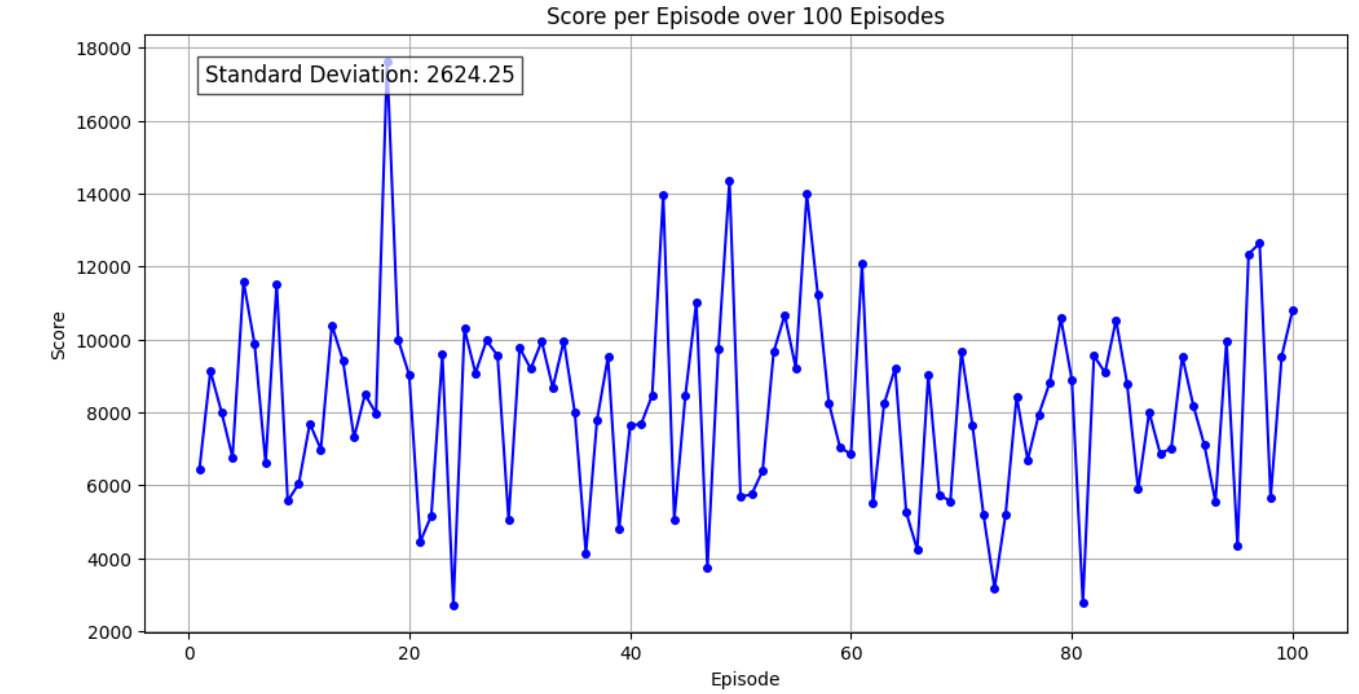

### Performance of agent 0

=== AI Performance Summary ===
Total Episodes: 100
Average Score: 5127.5
Best Score: 11420.0
Highest Tile Achieved: 512.0

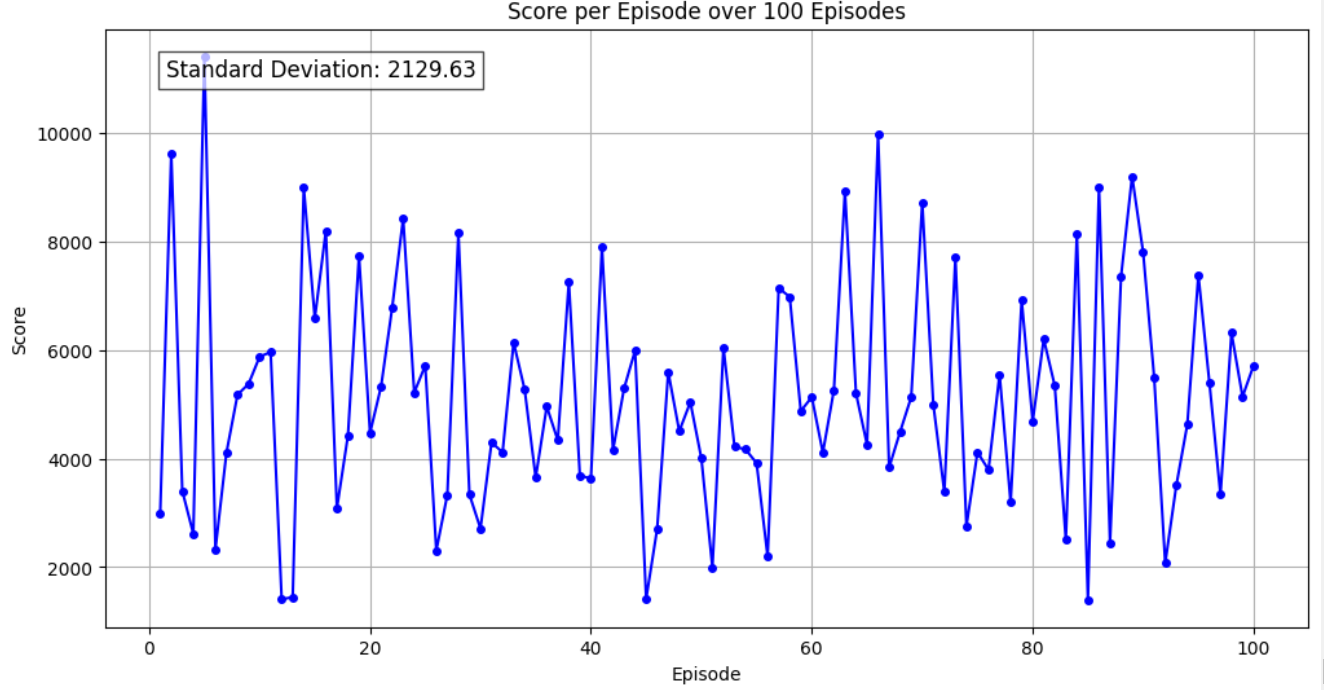

### Performance of agent 170

=== AI Performance Summary ===
Total Episodes: 100
Average Score: 5574.5
Best Score: 15128.0
Highest Tile Achieved: 1024.0

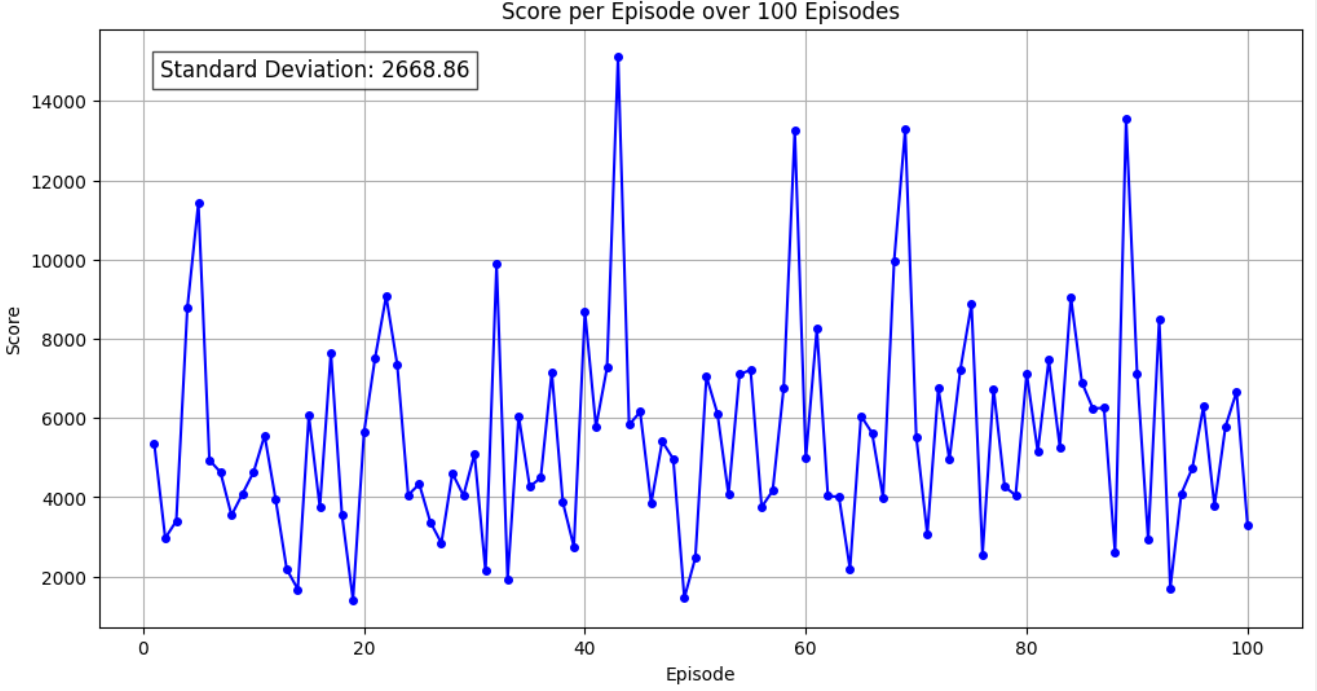

### Performance of agent 400

=== AI Performance Summary ===
Total Episodes: 100
Average Score: 5154.1
Best Score: 8600.0
Highest Tile Achieved: 512.0

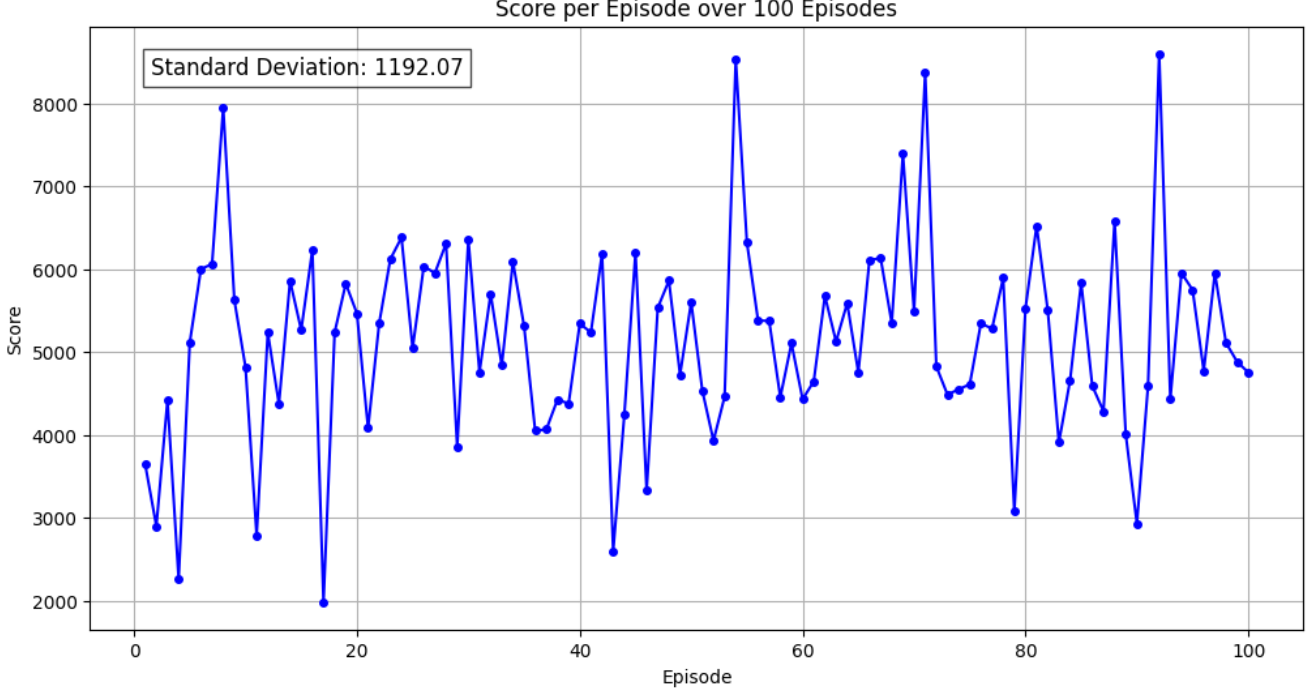